### [Permutation Feature Importance (PFI)](https://scikit-learn.org/stable/modules/permutation_importance.html)

- PFI can be used for any fitted estimator *when the data is tabular*. This is especially useful for non-linear or opaque estimators. 

- It is defined to be the *decrease in a model score when a single feature value is randomly shuffled*. The procedure breaks the relationship between the feature and the target, thus *a drop in the model score indicates how much the model depends on the feature*.

- This technique is *model agnostic* and can be calculated many times with different permutations.

- `permutation_importance` calculates the feature importance of estimators for a given dataset. `n_repeats` controls the #times a feature is randomly shuffled and returns a sample of feature importances.

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split as TTS
from sklearn.linear_model import Ridge

diabetes = load_diabetes()
X_train, X_val, y_train, y_val = TTS(
    diabetes.data, diabetes.target, random_state=0)

model = Ridge(alpha=1e-2).fit(X_train, y_train)
model.score(X_val, y_val)

0.35666062386954556

- Validation performance ($R2$ score) is significantly larger than chance. This enables using `permutation_importance` to learn which features are most predictive:

In [2]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{diabetes.feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

s5      0.204 +/- 0.050
bmi     0.176 +/- 0.048
bp      0.088 +/- 0.033
sex     0.056 +/- 0.023


- Permutation importances can be computed on a training set or  a held-out testing or validation set. Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.

### [Tree-based models: Impurity-based vs Permutation-based Performance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)

- Tree-based models provide an alternative measure of feature importances based on the mean decrease in impurity (MDI). 

- Impurity is quantified by the splitting criterion of the decision trees (Gini, Entropy or Mean Squared Error). However, *this method can give high importance to features that may not be predictive on unseen data* when the model is overfitting.

- Permutation-based feature importance avoids this issue, since it can be computed on unseen data.

- Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality (numerical features) over low cardinality (binary or categorical) variables with a small number of possible categories.

- Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions predictions and can be used to analyze any model class (not just tree-based models).

- The following example highlights the limitations of impurity-based feature importance in contrast to permutation-based feature importance: Permutation Importance vs Random Forest Feature Importance (MDI).

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

- *How to apply separate preprocessing* on different feature types. Two random variables added that are *not correlated* with the target variable, `survived`:

- `random_num`: high-cardinality (many unique values) numerical variable
- `random_cat`: low-cardinality (3 poss. values) categorical variable

In [13]:
# titanic dataset

X, y = fetch_openml("titanic", version=1, 
                    as_frame=True, return_X_y=True)

rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns   = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_encoder = OneHotEncoder(handle_unknown='ignore')

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
]).fit(X_train, y_train)

- Is the model's predictive ability sufficient? (Otherwise, why bother?)
- Result: Random Forest has enough capacity to completely memorize the training set, and can still generalize reasonably well.

- You could trade training accuracy for test set accuracy by tweaking tree capacity (`min_sample_leaf` to 5 or 10, for example). This could limit overfit while not introducing too much underfit.

In [14]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.817


- Impurity-based feature importance ranks *numerical variables* as most important - so `random_num` gets top billing.

- This is because:
    - Impurity-based importance is biased towards high-cardinality features.

<ipython-input-15-c7f094ae319d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


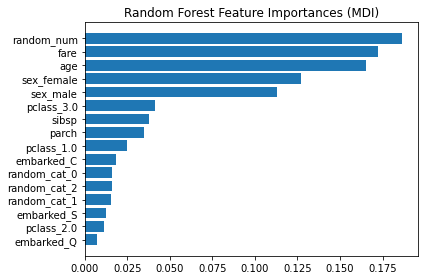

In [15]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat'])

feature_names = ohe.get_feature_names(
    input_features=categorical_columns)

feature_names = np.r_[feature_names, 
                      numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))

fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()

- Permutation importance, however, is computed on a reserved test set. In this case `sex` (a low-cardinality feature) is deemed most important.

- Also notice the two random features have very low scores.

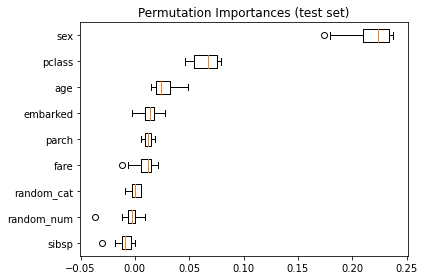

In [16]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()

- You can also compute a permutation importances on the training set. 

- This shows `random_num` gets a higher importance ranking. The difference is a *confirmation that the RF model has enough capacity to use that random numerical feature to overfit*. 

- You can further confirm this by re-running this example with a constrained RF with min_samples_leaf=10.

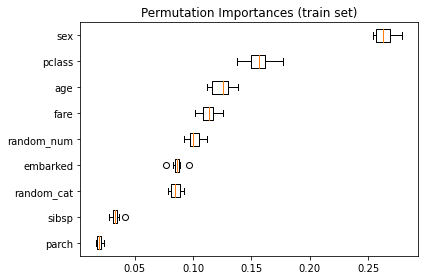

In [17]:
result = permutation_importance(rf, X_train, y_train, 
                                n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()

### [Example: Permutation Importance - Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)

- When two features are correlated, and one is permuted, the model still has access to the feature through the correlated one. This can result in lower performances for both - even though they *might* be important.

- One way to handle this is to cluster correleated features, and only keep one feature from each cluster.

In [18]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

- The Wisconsin breast cancer data set contains multicollinear features - so permutation importance says none of the features are important.

In [19]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


- A PI plot suggests none of the features are important, which contradicts the high test accuracy (*something* here must be important).

<ipython-input-21-89f8c7abfdd0>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])


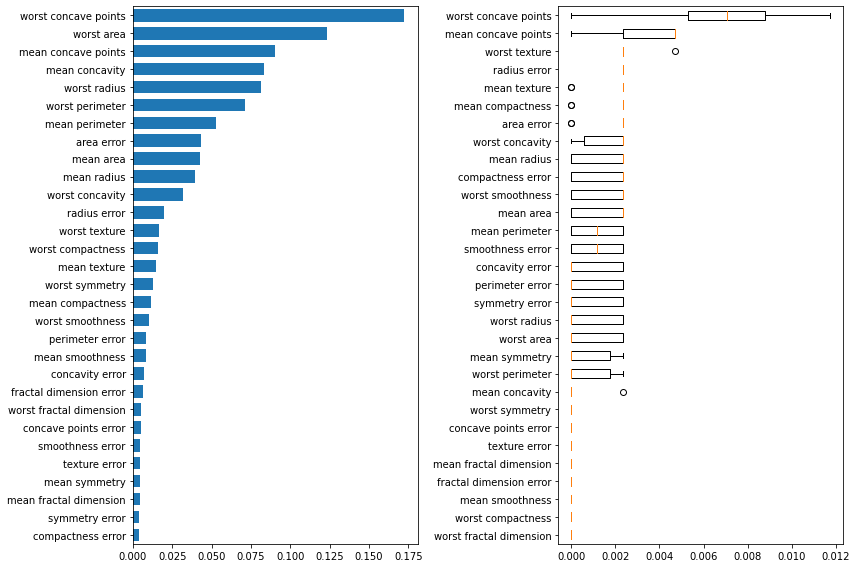

In [21]:
result = permutation_importance(clf, X_train, y_train, 
                                n_repeats=10,
                                random_state=42)

perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)

tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()

- When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. 

- One way to handle this is to apply *hierarchical clustering* on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. First, we plot a heatmap of the correlated features.

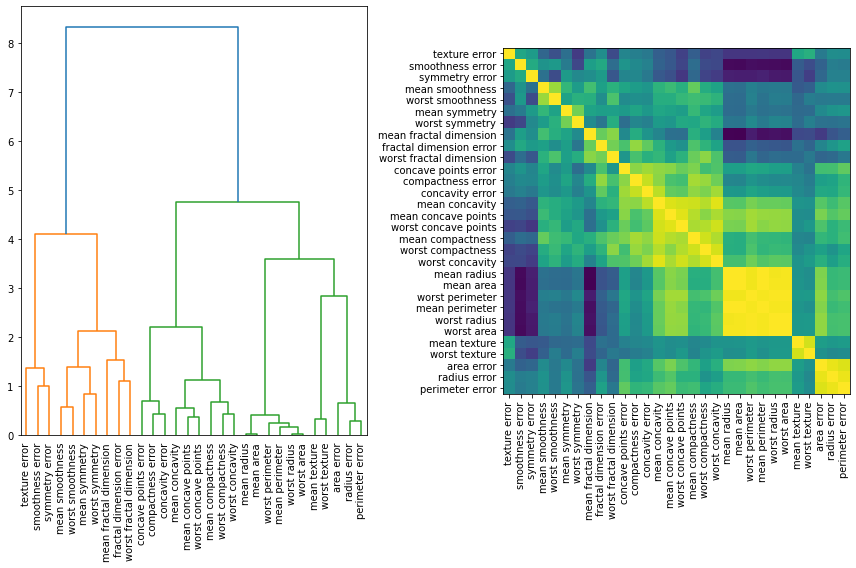

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

corr         = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro       = hierarchy.dendrogram(
    corr_linkage, 
    labels=data.feature_names.tolist(), 
    ax=ax1, leaf_rotation=90)

dendro_idx   = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()

-  Pick a threshold from a visual inspection of the dendrogram. Group features into clusters, choose a feature from each, select those features from the dataset, and train a new random forest.

- The test accuracy on the new dataset shouldn't change much.

In [23]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, 
                                 criterion='distance')

cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel  = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, 
                                 random_state=42).fit(X_train_sel, 
                                                      y_train)

print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.97
